<a href="https://colab.research.google.com/github/evysb/Tutorial_Detectron2/blob/main/Detectron2_infernece_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
!pip install -U kora

     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=69c59b425a5cebf70310681b614e7f18157ced190dce3b9b927364d1809ef56f
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 4.5MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import sys
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
#from kora.drive import upload_public
from IPython.display import HTML
def show_image(img):
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

Inferencia em uma imagem
1. Baixar uma imagem de exemplo
2. abrir imagem usando cv2
3. mostrar imagem

--2021-03-31 21:51:46--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.105.156
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.105.156|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K   880KB/s    in 0.2s    

2021-03-31 21:51:46 (880 KB/s) - ‘input.jpg’ saved [209222/209222]



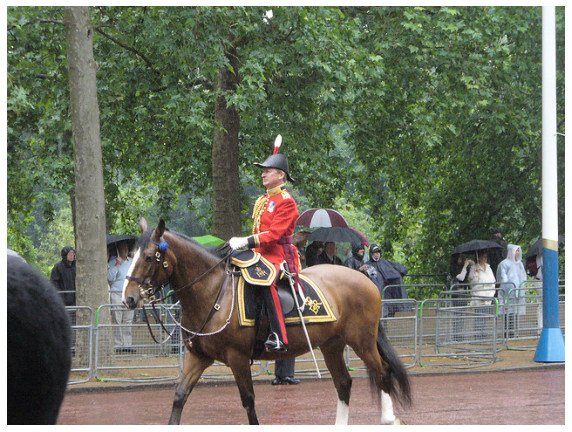

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg

im = cv2.imread("./input.jpg")
show_image(im[:,:,::-1])

Configuração e definição do modelo:

In [ ]:
cfg = get_cfg()
config_file="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:02, 65.7MB/s]                           


In [ ]:
metadata

Metadata(evaluator_type='coco', image_root='datasets/coco/train2017', json_file='datasets/coco/annotations/instances_train2017.json', name='coco_2017_train', thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy b

In [ ]:
classes = outputs["instances"].pred_classes.cpu().numpy()
masks = outputs['instances'].pred_masks.cpu().numpy()
boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
[metadata.thing_classes[c] for c in classes]

['horse',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'umbrella',
 'person',
 'umbrella',
 'umbrella',
 'person',
 'person',
 'backpack']

Visualização de resultado:

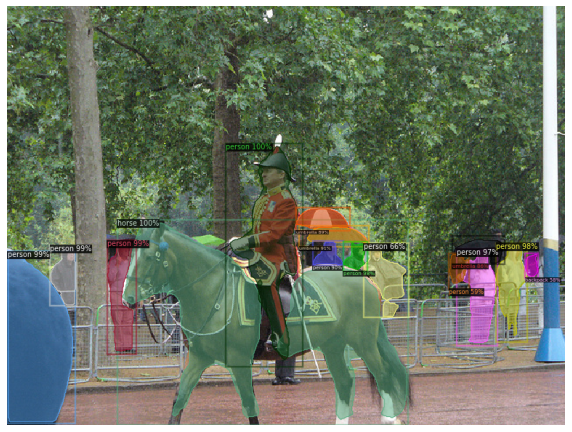

In [ ]:
v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(v.get_image())

# Camera Test

In [ ]:
#TODO:  USAR CODE SNIPPETS (CAMERA CAPTURE)
#TODO: REALIZAR INFERENCIA

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotReadableError: Could not start video source


# Video Test

Se apresenta um código que abre um vídeo e itera sobre todos os frames. Utiliza-se este código base para implemtar a inferência sobre um vídeo.

https://www.pexels.com/video/cars-on-highway-854671/

In [ ]:
video_input='Cars On Highway(3).mp4'
video_output='inference.mp4'

# Configuration input video
cap = cv2.VideoCapture(video_input)
frame_width, frame_height = (640,480)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Configuration output video
fourcc =cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(video_output,fourcc, 20.0, (frame_width, frame_height))

cfg = get_cfg()
config_file="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
predictor = DefaultPredictor(cfg)


for id_frame in tqdm(range(0,num_frames,10)):
  cap.set(cv2.CAP_PROP_POS_FRAMES,id_frame)
  flag, frame = cap.read()

  if flag:
    frame = cv2.resize(frame, (frame_width, frame_height))
    outputs = predictor(frame)
    v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_image(v.get_image())

    out_frame = # TODO: VISUALIZACAO

    out.write(out_frame[:,:,::-1].astype('uint8'))

cap.release()
out.release()